In [1]:
import pandas as pd
import numpy as np

from nltk import tokenize
from operator import itemgetter
import math
from tqdm import tqdm
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [10]:
## Load data

df = pd.read_csv('/home/amansinha/extractpubmed/timeline/tdm1_all.csv')
df = df.drop_duplicates()
df = df.drop(columns=['Unnamed: 0'], axis=1)
df['year'] = df['publication_date'].apply(lambda x: x.split('-')[0])

df

,pubmed_id,title,keywords,publication_date,abstract,year
0,7158680,The significance of natural killer activity in...,[],1982-12-01,A number of mouse strains of known F9 resistan...,1982
2,16347085,Conjugal Transfer of Bacteriophage Resistance ...,[],1986-06-01,Agar surface conjugal matings were used to int...,1986
3,2442724,A labile inhibitor blocks endo A gene transcri...,[],1987-08-11,The endo A gene encoding for an intermediate f...,1987
4,16347085,Conjugal Transfer of Bacteriophage Resistance ...,[],1986-06-01,Agar surface conjugal matings were used to int...,1986
6,21119056,Meiotic progression in Arabidopsis is governed...,[],2010-12-02,Meiosis is a modified cell division that produ...,2010
...,...,...,...,...,...,...
80,32737515,Post-neoadjuvant treatment with capecitabine a...,"['Breast cancer', 'Capecitabine', 'Radiochemot...",2020-08-02,Following neoadjuvant chemotherapy for breast ...,2020
81,32236828,Comparison of outcomes in a population-based c...,"['Cardiotoxicity', 'Heart failure', 'Overall s...",2020-04-03,Little data exist for comparing cardiac safety...,2020
82,32192389,Safety of trastuzumab after trastuzumab emtans...,"['Breast cancer', 'HER2', 'nodular regenerativ...",2020-03-21,Trastuzumab emtansine is an antibody-drug conj...,2020
83,32104023,Analysis of the Cost-Effectiveness of Liquid B...,"['biomarkers', 'breast cancer', 'cost-effectiv...",2020-02-28,Breast cancer is highly prevalent worldwide an...,2020


In [18]:
df1 = df.groupby('year')['abstract'].apply(list).reset_index(name='year_abstract')
df1

,year,year_abstract
0,1982,[A number of mouse strains of known F9 resista...
1,1986,[Agar surface conjugal matings were used to in...
2,1987,[The endo A gene encoding for an intermediate ...
3,2009,[A better understanding of tumor biology has l...
4,2010,[Meiosis is a modified cell division that prod...
5,2012,[Cell cycle control is modified at meiosis com...
6,2014,[To assess the presence of insulin resistance ...
7,2015,[Approximately 35% of patients with confirmed ...
8,2016,[This is preliminary study assessing the effic...
9,2017,[In this study we analyzed the mandibular cort...


In [110]:
all_keys = []
all_freq = []
for y,a in zip(df1['year'],df1['year_abstract']):
    #if len(a) ==1 : continue
    print(y,len(a))
    corpus = create_corpus(a)
    #print(corpus)
    df2 = freq_keyword(corpus)
    #print(df2)
    all_keys.append(df2['Keyword'])
    all_freq.append((*df2['Frequency'].tolist(), y))
    
    #print(tfidf_keyword(corpus,a))
cols = [f'#{i+1}' for i in range(20)]+['year']
cols
df2 = pd.DataFrame(all_freq, columns=[f'#{i+1}' for i in range(20)]+['year'])    

1982 1
1986 2
1987 1
2009 2
2010 1
2012 2
2014 2
2015 8
2016 16
2017 2
2018 14
2019 12
2020 14
2021 1


In [54]:
def create_corpus(a):
    #print('==',a)
    corpus = []
    ds_count = len(a)
    for i in range(0, ds_count):
        # Remove punctuation
        text = re.sub('[^a-zA-Z]', ' ', str(a[i]))

        # Convert to lowercase
        text = text.lower()

        # Remove tags
        #text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # Remove special characters and digits
        #text=re.sub("(\\d|\\W)+"," ",text)

        # Convert to list from string
        text = text.split()

        # Stemming
        ps=PorterStemmer()
        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
        return corpus

In [26]:
## frequency based extraction
def freq_keyword(corpus):

    # View most frequently occuring keywords
    def get_top_n_words(corpus, n=None):
        vec = CountVectorizer().fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in      
                       vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], 
                           reverse=True)
        return words_freq[:n]

    # Convert most freq words to dataframe for plotting bar plot, save as CSV
    top_words = get_top_n_words(corpus, n=20)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Keyword", "Frequency"]
    
    return top_df

In [106]:
df2

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#12,#13,#14,#15,#16,#17,#18,#19,#20,year
0,6,5,4,4,4,4,3,3,3,2,...,2,2,2,2,2,2,2,2,2,1982
1,11,7,7,6,6,4,4,4,3,3,...,3,2,2,2,2,2,2,2,2,1986
2,16,9,8,7,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,1987
3,7,5,4,4,4,3,3,3,3,2,...,2,2,2,2,2,2,2,1,1,2009
4,7,6,5,5,4,4,4,3,3,3,...,2,2,2,2,2,2,2,1,1,2010
5,9,6,6,5,5,4,4,4,3,3,...,3,2,2,2,2,2,2,2,2,2012
6,9,6,5,5,4,4,3,3,3,3,...,3,3,2,2,2,2,2,2,2,2014
7,4,4,3,3,3,2,2,2,2,2,...,2,2,2,2,1,1,1,1,1,2015
8,7,7,5,4,4,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2016
9,8,8,7,7,5,4,4,4,3,3,...,3,3,3,3,3,3,2,2,2,2017


In [115]:
all_keys

[0          target
 1            cell
 2         natural
 3          killer
 4             yac
 5           lysis
 6      resistance
 7           vitro
 8            line
 9          strain
 10         tested
 11       activity
 12        pattern
 13            low
 14           cold
 15    competition
 16     experiment
 17      embryonal
 18      carcinoma
 19            pcc
 Name: Keyword, dtype: object,
 0               phage
 1            cremoris
 2     transconjugants
 3                 ptr
 4           resistant
 5            conjugal
 6             plasmid
 7                 lac
 8              mating
 9          resistance
 10                 hp
 11             lactis
 12          sensitive
 13                hsp
 14        determinant
 15      streptococcus
 16                 kh
 17                tdm
 18             strain
 19             select
 Name: Keyword, dtype: object,
 0                 cell
 1                 gene
 2                  pcc
 3                 endo
 4

[(0, 8, 2020), (1, 7, 2020), (2, 4, 2020), (3, 4, 2020), (4, 3, 2020), (5, 3, 2020), (6, 3, 2020), (7, 3, 2020), (8, 3, 2020), (9, 2, 2020), (10, 2, 2019), (11, 2, 2019), (12, 2, 2019), (13, 2, 2019), (14, 2, 2019), (15, 2, 2019), (16, 2, 2019), (17, 2, 2019), (18, 2, 2019), (19, 2, 2019)]
20 20 20
20 20 20


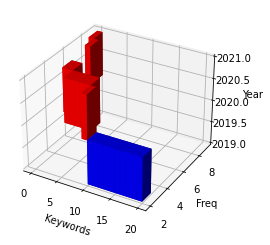

In [79]:
# 3D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')


xpos = list(range(20))#df2['Keyword'].tolist()#
ypos = df2['Frequency'].tolist()
zpos = [2020]*10 + [2019]*10

print(list(zip(xpos,ypos,zpos)))
print(len(xpos), len(ypos), len(zpos))

dx = np.ones(20)
dy = np.ones(20)
dz = np.ones(20)#list(range(2000,2020))

print(len(dx), len(dy), len(dz))

ax1.bar3d(xpos[:10], ypos[:10], zpos[:10], dx[:10], dy[:10],dz[:10], color='r')
ax1.bar3d(xpos[10:], ypos[10:], zpos[10:], dx[10:], dy[10:],dz[10:], color='b')
ax1.set_xlabel('Keywords')
ax1.set_ylabel('Freq')
ax1.set_zlabel('Year')

plt.show()

In [111]:
columns = df2['year'].tolist()
df2.drop('year', axis=1, inplace=True)
df3 = df2.values
#print(df3)

[[ 6  5  4  4  4  4  3  3  3  2  2  2  2  2  2  2  2  2  2  2]
 [11  7  7  6  6  4  4  4  3  3  3  3  2  2  2  2  2  2  2  2]
 [16  9  8  7  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2]
 [ 7  5  4  4  4  3  3  3  3  2  2  2  2  2  2  2  2  2  1  1]
 [ 7  6  5  5  4  4  4  3  3  3  2  2  2  2  2  2  2  2  1  1]
 [ 9  6  6  5  5  4  4  4  3  3  3  3  2  2  2  2  2  2  2  2]
 [ 9  6  5  5  4  4  3  3  3  3  3  3  3  2  2  2  2  2  2  2]
 [ 4  4  3  3  3  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1]
 [ 7  7  5  4  4  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2]
 [ 8  8  7  7  5  4  4  4  3  3  3  3  3  3  3  3  3  2  2  2]
 [ 3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 6  6  6  5  4  4  3  3  3  2  2  2  2  2  2  1  1  1  1  1]
 [ 5  4  3  3  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1]
 [ 8  7  4  4  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2]]


In [121]:
len(columns)

14

<ipython-input-124-3c6aca3ef039>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.w_xaxis.set_ticklabels(columns)
<ipython-input-124-3c6aca3ef039>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.w_yaxis.set_ticklabels(rows)


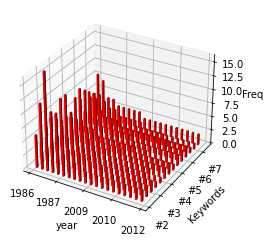

In [124]:
#### trying again !!!!

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

rows = [f'#{i+1}' for i in range(20)]
lx = len(df3[0])
ly = len(df3[:,0])

xpos = np.arange(0,lx,1)#list(range(20))#df2['Keyword'].tolist()#
ypos = np.arange(0,ly,1)#[2020]*10 + [2019]*10

xpos, ypos = np.meshgrid(xpos + 0.25, ypos + 0.25)

"""Setting x, y and z positions"""
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

#print(list(zip(xpos,ypos,zpos)))
#print(len(xpos), len(ypos), len(zpos))


dx = 0.25*np.ones_like(zpos)
dy = dx.copy()
dz = df3.flatten()#np.zeros(20*20)#list(range(2000,2020))

#print(len(dx), len(dy), len(dz))
#print(dx,dy,dz)
colors = ['red', 'yellow', 'brown', 'cyan', 
          'green', 'pink', 'orange', 'blue',
          'purple', 'gray', 'black', 'white',
          'magenta', 'darkred']*ly
ax1.bar3d(xpos, ypos, zpos, dx, dy,dz, color='red')

"""Set the x and y ticks"""
ax1.w_xaxis.set_ticklabels(columns)
ax1.w_yaxis.set_ticklabels(rows)

#ax1.bar3d(xpos[:10], ypos[:10], zpos[:10], dx[:10], dy[:10],dz[:10], color='r')
#ax1.bar3d(xpos[10:], ypos[10:], zpos[10:], dx[10:], dy[10:],dz[10:], color='b')
ax1.set_xlabel('year')
ax1.set_ylabel('Keywords')
ax1.set_zlabel('Freq')

plt.show()

In [37]:
def tfidf_keyword(corpus,a):

    cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=None, ngram_range=(1,3))
    X=cv.fit_transform(corpus)

    from sklearn.feature_extraction.text import TfidfTransformer 
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(X)

    # Get feature names
    feature_names=cv.get_feature_names()
 
    # Fetch document for which keywords needs to be extracted
    doc=' '.join(corpus)#[ds_count-1]

    # Generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #Sort tf_idf in descending order
    from scipy.sparse import coo_matrix
    def sort_coo(coo_matrix):
        tuples = zip(coo_matrix.col, coo_matrix.data)
        return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

    def extract_topn_from_vector(feature_names, sorted_items, topn=25):

        # Use only topn items from vector
        sorted_items = sorted_items[:topn]
        score_vals = []
        feature_vals = []

        # Word index and corresponding tf-idf score
        for idx, score in sorted_items:

            # Keep track of feature name and its corresponding score
            score_vals.append(round(score, 3))
            feature_vals.append(feature_names[idx])

        # Create tuples of feature,score
        # Results = zip(feature_vals,score_vals)
        results= {}
        for idx in range(len(feature_vals)):
            results[feature_vals[idx]]=score_vals[idx]
        return results

    # Sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    # Extract only the top n; n here is 25
    keywords=extract_topn_from_vector(feature_names,sorted_items,25)

    # Print the results, save as CSV
    #print()
    tfidf_df = pd.DataFrame(list(keywords.items()))
    tfidf_df.columns=["Keyword", "Score"]
    return tfidf_df